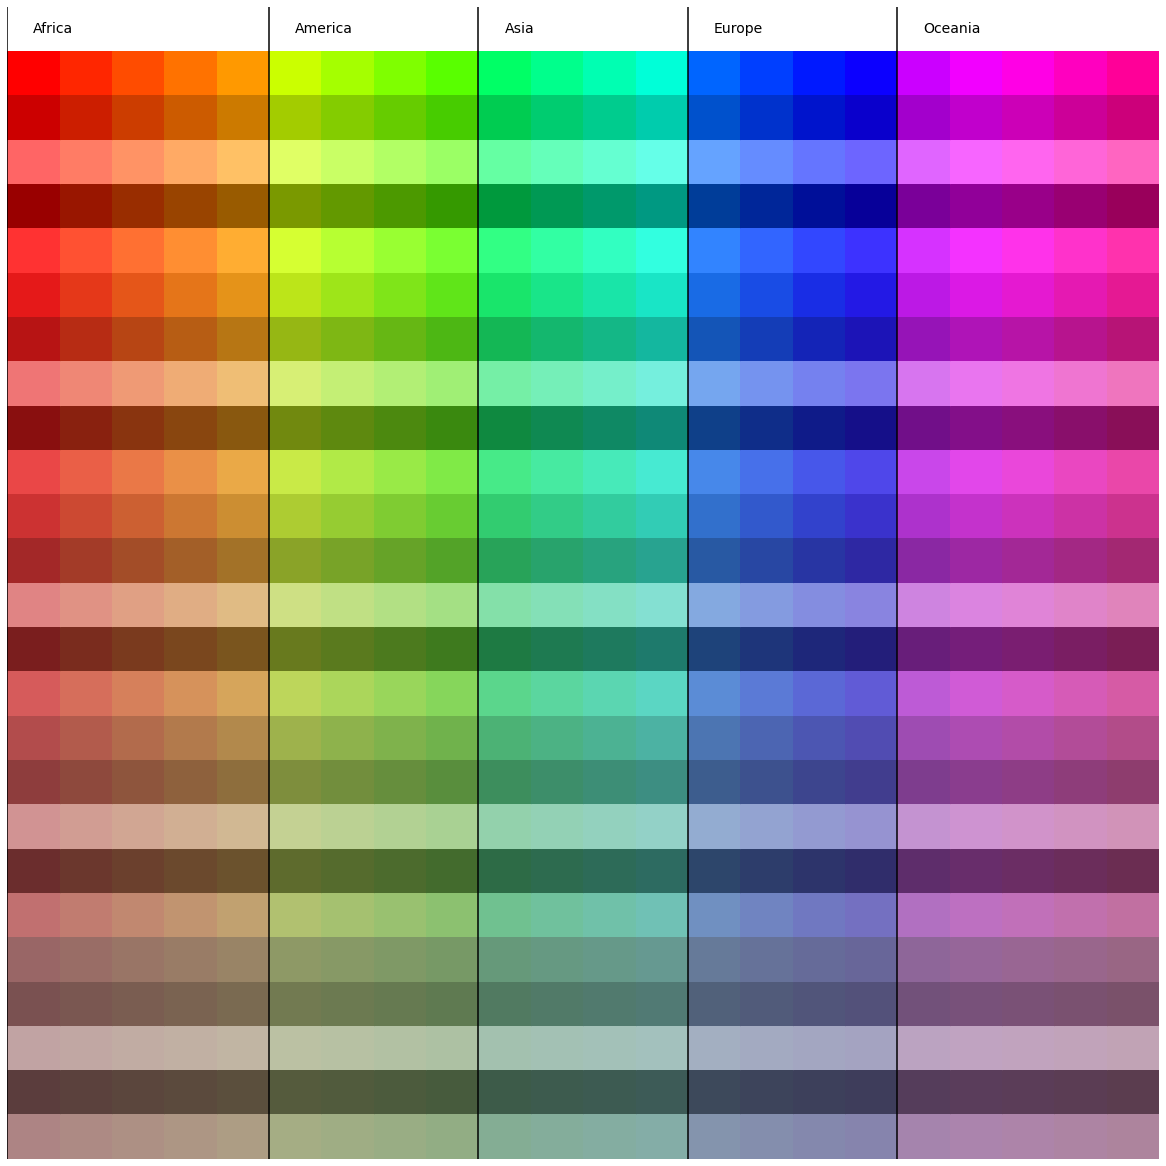

In [20]:
import csv
import webcolors 
import colorsys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatch




def gen_gco_palette(h_base, l_value, s_value):


	df = pd.DataFrame(columns=["continent_code","continent_label", "area_code", "color_continent", "color_area", "color_hex", "color_code"])


	df_row = 0
	area_code = 0

	for item in base_arr:


		#create loop for each area
		color_continent = colorsys.hls_to_rgb(h_base, 0.5, 1)
		color_continent = [int(x*255.0) for x in color_continent]
		color_continent = webcolors.rgb_to_hex(color_continent)

		h_span = 0

		for i_area in range(item[2]):
			# print(h_span[i_area])

			h_base_area = h_base + h_span
			color_area = colorsys.hls_to_rgb(h_base_area, 0.5, 1)
			color_area = [int(x*255.0) for x in color_area]
			color_area = webcolors.rgb_to_hex(color_area)
			area_code += 1
			color_code= 1
			for s_temp in s_value:
				for l_temp in l_value:
					color_temp = colorsys.hls_to_rgb(h_base_area, l_temp, s_temp)
					color_temp = [int(x*255.0) for x in color_temp]
					color_temp = webcolors.rgb_to_hex(color_temp)
					df.at[df_row, 'continent_code'] = item[0]
					df.at[df_row, 'continent_label'] = item[1]
					df.at[df_row, 'area_code'] = area_code
					df.at[df_row, 'color_continent'] = color_continent
					df.at[df_row, 'color_area'] = color_area
					df.at[df_row, 'color_code'] = color_code
					df.at[df_row, 'row_number'] = df_row
					df.at[df_row, 'color_hex'] = color_temp
					color_code+=1
					df_row+=1

			h_span += 0.025

		h_base += 0.2

	
				

	fig = plt.figure(figsize=[16, 16])
	ax = fig.add_axes([0, 0, 1, 1])



	for index, row in df.iterrows():


		
		plot_x = row['area_code']-1
		plot_y = 25-row['color_code']

		r1 = mpatch.Rectangle((plot_x, plot_y), 1, 1, color=row['color_hex'])
		ax.add_patch(r1)
		# ax.add_patch(r2)

		if row['color_hex'] ==  row['color_continent']:
			 ax.axvline(plot_x, color='k')
			 ax.text(plot_x+0.5, 25.5,  row['continent_label'], va='center', fontsize=14)

		

	ax.set_xlim(0, 22)
	ax.set_ylim(0, 26)
	ax.axis('off')



	return df, plt



#continent color 

# #continent code, continent_label, nb_area per continent
base_arr =[[1, "Africa", 5], [2, "America", 4], [4, "Asia",4], [5, "Europe",4],[6, "Oceania",5]]

hue_base = 0
saturation_value = [1,0.8,0.6,0.4,0.2]
lightness_value =  [0.5,0.4,0.7,0.3,0.6]

df_palette, plot_palette = gen_gco_palette(hue_base,lightness_value,saturation_value)
plot_palette.show()
